## Import all relevant libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs as tfdocs
from keras.optimizers import adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM,Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

## Data Visualization

In [2]:
abl = pd.read_csv('ABL PA Equity Diff.csv')
abl.tail()

,Open,High,Low,Close,Volume
3946,3.55,-3.09,2.54,-2.56,-50000.0
3947,-0.02,4.94,-4.96,-2.17,55500.0
3948,-3.88,-6.97,1.96,-0.83,-13500.0
3949,-0.51,-1.12,-0.50,-0.06,-12500.0
3950,0.31,4.81,-0.14,3.79,41500.0


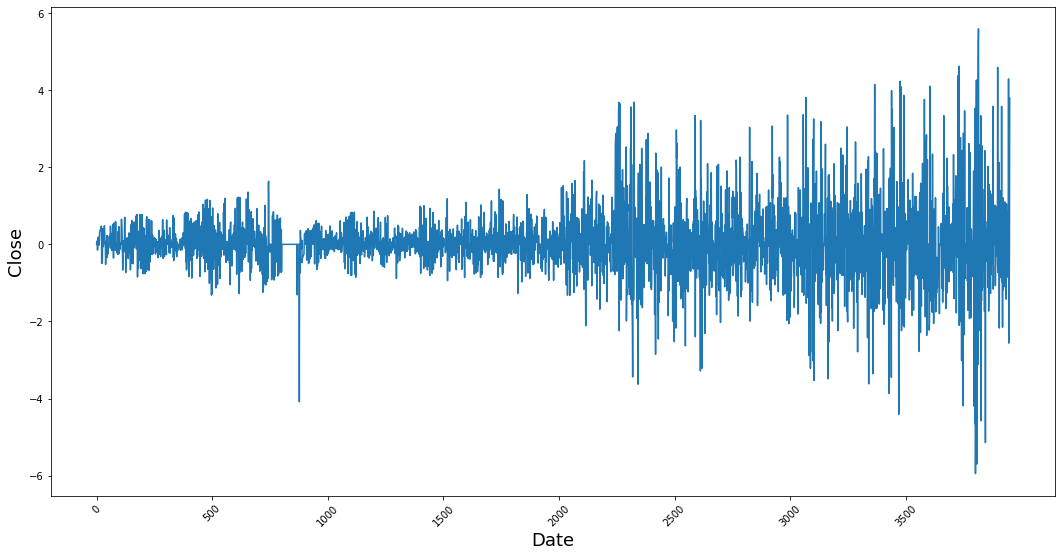

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(abl.shape[0]), abl['Close'])
plt.xticks(range(0, abl.shape[0], 500), rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.show()

## Test-Train Split

In [4]:
def test_train_split(df):

    close_prices = df['Close'] #We choose to predict the close price

    # 80-20 split into Train-Test

    train_data = close_prices[:int(len(close_prices)*0.8)]
    test_data = close_prices[int(len(close_prices)*0.8):]

    train_data = np.asarray(train_data)
    test_data = np.asarray(test_data)

    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)

    print(train_data.shape[0])
    print(test_data.shape[0])
    
    return train_data, test_data
    
train_data, test_data = test_train_split(abl)

3160
791


## Check distribution of data

{'whiskers': [<matplotlib.lines.Line2D at 0x276d0283388>,
 'caps': [<matplotlib.lines.Line2D at 0x276d0283ec8>,
 'boxes': [<matplotlib.patches.PathPatch at 0x276d027dcc8>],
 'medians': [<matplotlib.lines.Line2D at 0x276d0281e88>],
 'fliers': [<matplotlib.lines.Line2D at 0x276d028bec8>],
 'means': []}

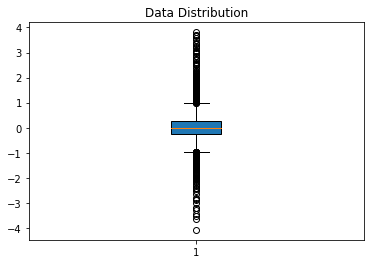

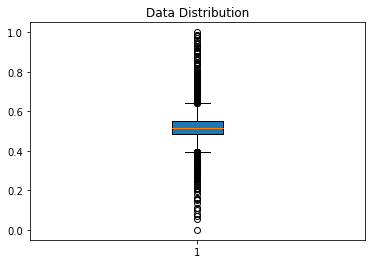

In [5]:
fig1, ax1 = plt.subplots()
ax1.set_title('Data Distribution')
ax1.boxplot(train_data, patch_artist=True)

tempScaler = MinMaxScaler()
scaled_data = tempScaler.fit_transform(train_data)

fig1, ax1 = plt.subplots()
ax1.set_title('Data Distribution')
ax1.boxplot(scaled_data, patch_artist=True)




We can see scaling our data does not change the distribution

## Prepare Train set

In [6]:
temp = []
temp.append(train_data[0:60])
len(temp[0])

60

In [7]:
def train_prep(train_data):

    scaler = MinMaxScaler((-1, 1))
    scaled_train_data = scaler.fit_transform(train_data)

    x_train = [] #Features
    y_train = [] #Labels

    for i in range(60, scaled_train_data.shape[0]): #Make windows of 60 days for training until last day

        x_train.append(train_data[i-60:i]) #60 day window
        y_train.append(train_data[i, 0]) #60th day price

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    print(x_train.shape, y_train.shape, scaler.scale_)
    
    return x_train, y_train, scaler.scale_
    
x_train, y_train, scale_train = train_prep(train_data)

(3100, 60, 1) (3100,) [0.25345009]


## Prepare test set

In [8]:
def test_prep(test_data, train_data):
    
    scaler = MinMaxScaler((-1, 1))
    test_data = np.concatenate((train_data[:60], test_data), axis = 0) #Add last 60 observations of train data to test
    scaled_test_data = scaler.fit_transform(test_data)

    x_test = []
    y_test = []

    for i in range(60, test_data.shape[0]):
        x_test.append(test_data[i-60:i])
        y_test.append(test_data[i, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
        
    print(x_test.shape, y_test.shape, scaler.scale_)
    return x_test, y_test, scaler.scale_
    
x_test, y_test, test_scale = test_prep(test_data, train_data)

(791, 60, 1) (791,) [0.17341692]


## Building the LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


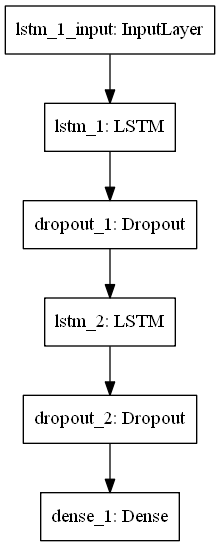

In [9]:
model = Sequential()

model.add(LSTM(units = 64, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

plot_model(model, to_file='model.png')

In [10]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data = (x_test, y_test), verbose = 1)






Train on 3100 samples, validate on 791 samples
Epoch 1/50
3100/3100 [==============================] - 14s 5ms/step - loss: 0.4582 - accuracy: 0.1029 - val_loss: 1.9144 - val_accuracy: 0.0999
Epoch 2/50
3100/3100 [==============================] - 13s 4ms/step - loss: 0.4578 - accuracy: 0.1029 - val_loss: 1.9132 - val_accuracy: 0.0999
Epoch 3/50
3100/3100 [==============================] - 12s 4ms/step - loss: 0.4574 - accuracy: 0.1029 - val_loss: 1.9128 - val_accuracy: 0.0999
Epoch 4/50
3100/3100 [==============================] - 12s 4ms/step - loss: 0.4576 - accuracy: 0.1029 - val_loss: 1.9108 - val_accuracy: 0.0999
Epoch 5/50
3100/3100 [==============================] - 12s 4ms/step - loss: 0.4575 - accuracy: 0.1029 - val_loss: 1.9118 - val_accuracy: 0.0999
Epoch 6/50
3100/3100 [==============================] - 12s 4ms/step - loss: 0.4569 - accuracy: 0.1029 - val_loss: 1.9133 - val_accuracy: 0.0999
Epoch 7/50
3100/3100 [==============================] - 12s 4ms/step - loss: 0.456

In [11]:
#model = keras.models.load_model(filepath)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

791/791 [==============================] - 1s 1ms/step
[2.011200209483787, 0.09734513610601425]


## Testing

In [12]:
y_hat = model.predict(x_test)


In [13]:
y_hat_unscaled = y_hat/test_scale[0]
y_test_unscaled = y_test/test_scale[0]


In [14]:
y_hat_unscaled[-32]

array([-0.47412717], dtype=float32)

In [15]:
from sklearn.metrics import mean_squared_error
acc = 100 - mean_squared_error(y_test, y_hat)
print('Accuracy = ', acc, '%')

Accuracy =  97.98879976916892 %


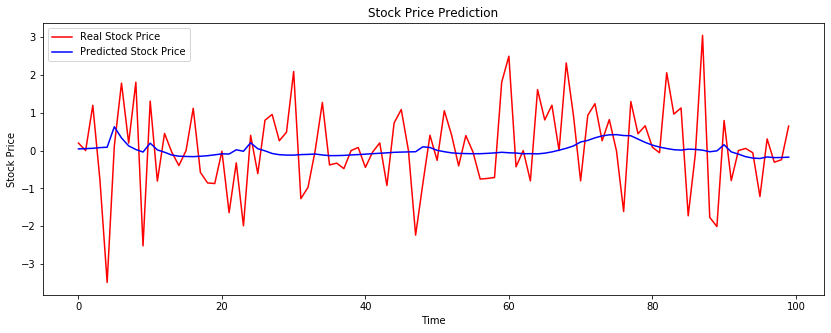

In [19]:
def plot_comparison(y_test, y_hat):

    plt.figure(figsize=(14,5))
    plt.plot(y_test[:100], color = 'red', label = 'Real Stock Price')
    plt.plot(y_hat[:100], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_comparison(y_test, y_hat)

In [17]:
print('Next day price:', y_hat[-1][-1])

Next day price: -0.41328636


## Predicting future prices



In [18]:
y_hat_unscaled

array([[ 2.49286205e-01],
       [ 3.00399989e-01],
       [ 3.41536820e-01],
       [ 4.49949741e-01],
       [ 5.06573737e-01],
       [ 3.62663531e+00],
       [ 1.91775465e+00],
       [ 7.15418875e-01],
       [ 1.57055661e-01],
       [-2.25118607e-01],
       [ 1.12943387e+00],
       [ 9.93939564e-02],
       [-2.56051809e-01],
       [-6.78625286e-01],
       [-8.55164647e-01],
       [-8.99192572e-01],
       [-9.24248636e-01],
       [-8.67106497e-01],
       [-7.84796357e-01],
       [-6.48830354e-01],
       [-4.98746574e-01],
       [-5.25554776e-01],
       [ 1.16507970e-01],
       [-1.04627714e-01],
       [ 1.18529487e+00],
       [ 2.80319393e-01],
       [-4.09932546e-02],
       [-4.45562631e-01],
       [-6.29721522e-01],
       [-6.89529896e-01],
       [-6.93970442e-01],
       [-6.16171956e-01],
       [-5.83415389e-01],
       [-5.28046191e-01],
       [-6.71851039e-01],
       [-7.73194253e-01],
       [-7.67087162e-01],
       [-7.35553563e-01],
       [-6.6